# 네이버 영화 리뷰 감성 분석

    차이점 
        1. 리뷰 길이를 최소 20로 설정


## 1. 데이터 처리

In [1]:
import pandas as pd

df = pd.read_csv('naver_movie_reviews_limit_length.csv')
df.head()
print("data size : ",len(df))

data size :  444351


In [2]:
# review 중복 제거, null 값 제거

df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
print("data size : ",len(df))

data size :  443742


In [3]:
# 영어 review 있었는 지 확인
df.isnull().sum()

review    0
rating    0
label     0
dtype: int64

## 긍정/중립/부정 데이터

2    228702
1    141113
0     73927
Name: label, dtype: int64


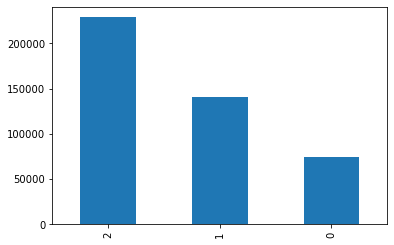

In [4]:
df['label'].value_counts().plot(kind='bar')
print(df['label'].value_counts())

max length :  140
mean length :  45.00436965624169


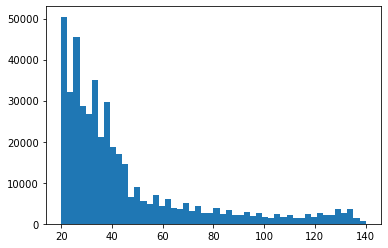

In [5]:
import numpy as np
import matplotlib.pyplot as plt

print("max length : ",max(len(review) for review in df['review']))
print("mean length : ",np.mean([len(review) for review in df['review']]))
plt.hist([len(review) for review in df['review']],bins=50);

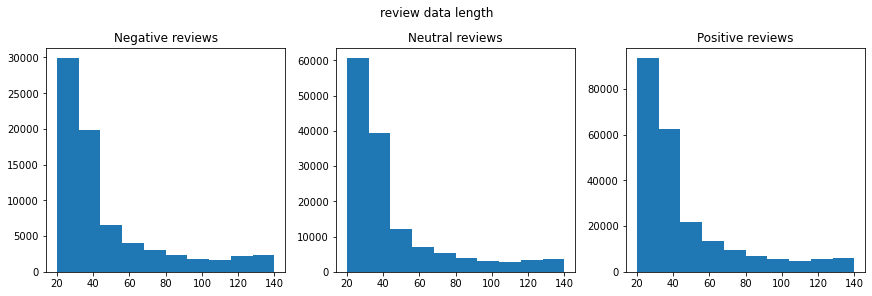

In [6]:
fig, axes = plt.subplots(1,3,figsize=(12,4),constrained_layout=True)
fig.suptitle("review data length")

axes[0].hist([len(review) for review,label in zip(df['review'],df['label']) if label == 0])
axes[0].set_title("Negative reviews")
axes[1].hist([len(review) for review,label in zip(df['review'],df['label']) if label == 1])
axes[1].set_title("Neutral reviews")
axes[2].hist([len(review) for review,label in zip(df['review'],df['label']) if label == 2])
axes[2].set_title("Positive reviews");

0    73927
1    73927
2    73927
Name: label, dtype: int64


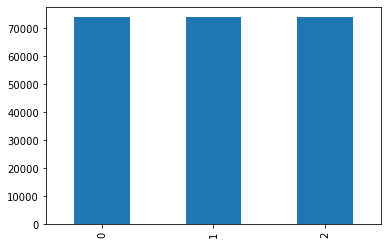

In [7]:
# 데이터가 긍정 레이블에 치중되어 있다. , 제일 적은 부정 개수로 설정(73927)
# 리뷰 길이의 분포는 각 레이블 별 유사하다.


df = df.sample(frac=1).groupby('label').head(73927)
df['label'].value_counts().plot(kind='bar')
print(df['label'].value_counts())

In [8]:
# train / test 데이터 나눠준다.

from sklearn.model_selection import train_test_split

X = df['review']
y = df['label']

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print("train size : ",len(X_train_data))
print("test size : ",len(X_test_data))

train size :  177424
test size :  44357


## 텍스트 처리
    한글 자연어 처리 라이브러리인 Okt 사용.
    불용어는 https://bab2min.tistory.com/544 참고. 

In [10]:
f = open('stopwords.txt')
stopwords = []
for line in f :
    stopwords.append(line.split("\t")[0])

print(len(stopwords))

100


In [11]:
from konlpy.tag import Okt
from tqdm import tqdm

okt = Okt()

X_train_token = []
for sent in tqdm(X_train_data) :
    tmp = [] 
    tmp = okt.morphs(sent,stem=True)
    tmp = [word for word in tmp if word not in stopwords]
    X_train_token.append(tmp)

X_train_token[:3]

100%|██████████| 177424/177424 [04:58<00:00, 594.86it/s]


[['소재', '만큼', '새롭다', '못', '진부하다', '스토리', '전개'],
 ['진짜', '재밌다', '특히', '키루루', '괴물', '로', '변하다', '재밌다'],
 ['편', '과', '이어지다', '에서는', '좋다', '한편', '으로', '아쉽다', '기도', '하다', '작품', 'ㅠ']]

In [12]:
X_test_token = []
for sent in tqdm(X_test_data) :
    tmp = [] 
    tmp = okt.morphs(sent,stem=True)
    tmp = [word for word in tmp if word not in stopwords]
    X_test_token.append(tmp)
    
X_test_token[:3]

100%|██████████| 44357/44357 [01:24<00:00, 522.52it/s]


[['잉', '거품', '정말', '심다', '평점', '에', '낚였다', '이렇다', 'ㅎㅎㅎ'],
 ['패러디',
  '물',
  '영화',
  '임',
  '너무',
  '인위',
  '인',
  '웃음',
  '을',
  '유발',
  '하다',
  '하다',
  '티',
  '확남'],
 ['이렇다', '소재', '로', '좀더', '감동', '을', '줄', '있다']]

In [13]:
# threshold 확인

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_token)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0   # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 51985
등장 빈도가 2번 이하인 희귀 단어의 수: 27778
단어 집합에서 희귀 단어의 비율: 53.43464460902183
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2514955818590952


In [14]:
# 0번 패딩 토큰 , 1번 OOV 토큰 고려 +2
vocab_size = total_cnt - rare_cnt + 2 
print(vocab_size)

24209


In [15]:
# 정수 인코딩
tokenizer = Tokenizer(num_words=vocab_size,oov_token='OOV')
tokenizer.fit_on_texts(X_train_token)
X_train = tokenizer.texts_to_sequences(X_train_token)
X_test = tokenizer.texts_to_sequences(X_test_token)

In [16]:
import numpy as np

y_train = np.array(y_train_data)
y_test = np.array(y_test_data)

In [17]:
# 빈도수 낮은 단어 삭제 -> 빈 샘플 존재

drop_idx = [idx for idx, sent in enumerate(X_train) if len(sent) < 1]

X_train = np.delete(X_train,drop_idx,axis=0)
y_train = np.delete(y_train,drop_idx,axis=0)

print("X_train size : ",len(X_train))
print("y_train size : ",len(y_train))

X_train size :  177422
y_train size :  177422


## 패딩

max length of reivews :  70
mean length of reivews :  15.404233973238945


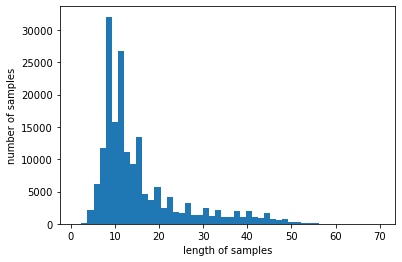

In [18]:
import matplotlib.pyplot as plt

print("max length of reivews : ",max(len(word) for word in X_train))
print("mean length of reivews : ",np.mean([len(word) for word in X_train]))
plt.hist([len(word) for word in X_train],bins=50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

In [19]:
def belowThreshold(thre, words) :
    cnt = 0
    for word in words:
        if(len(word) <= thre) :
            cnt += 1
    print(f"percentage of sample that shorter threshold {thre} : {round((cnt / len(words)) * 100,3)}")
    
print("threshold : 30")
belowThreshold(30,X_train)
print("threshold : 40")
belowThreshold(40,X_train)

threshold : 30
percentage of sample that shorter threshold 30 : 89.993
threshold : 40
percentage of sample that shorter threshold 40 : 95.894


In [20]:
# 최대 길이 40으로 맞춤
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 40
X_train = pad_sequences(X_train,maxlen = max_len)
X_test = pad_sequences(X_test,maxlen = max_len)

In [21]:
# 원-핫 인코딩.
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train,3)
y_test = to_categorical(y_test,3)

## 모델 구축

### 문장 예측 함수

In [22]:
def sent_predict(sent,model) :
    sent = okt.morphs(sent,stem=True)
    sent = [word for word in sent if word not in stopwords]
    encoded = tokenizer.texts_to_sequences([sent])
    padded = pad_sequences(encoded,maxlen=max_len)
    score = model.predict(padded)
    idx = np.argmax(score[0])
    if idx == 0 :
        print("{} % Negative review".format(round(score[0][idx]*100,2)))
    elif idx == 1:
        print("{} % Neutral review".format(round(score[0][idx]*100,2)))
    else :
        print("{} % Positive review".format(round(score[0][idx]*100,2)))

### GRU

In [23]:
# 조기 종료 요건과 베스트 모델 저장
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4)

mc = ModelCheckpoint('NAVER_GRU.h5',monitor='val_acc',mode='max',verbose=1,
                    save_best_only=True)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU,Embedding,Dense

model = Sequential()
model.add(Embedding(vocab_size,100))
model.add(GRU(128))
model.add(Dense(3,activation='softmax'))

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['acc'])

model.fit(X_train,y_train,epochs=15,callbacks=[es,mc],
          batch_size=60,validation_data=(X_test,y_test))

Epoch 1/15
2958/2958 [==============================] - 208s 70ms/step - loss: 0.8362 - acc: 0.6052 - val_loss: 0.7416 - val_acc: 0.6640

Epoch 00001: val_acc improved from -inf to 0.66398, saving model to NAVER_GRU.h5
Epoch 2/15
2958/2958 [==============================] - 256s 86ms/step - loss: 0.6702 - acc: 0.7032 - val_loss: 0.7413 - val_acc: 0.6609

Epoch 00002: val_acc did not improve from 0.66398
Epoch 3/15
2958/2958 [==============================] - 252s 85ms/step - loss: 0.5902 - acc: 0.7443 - val_loss: 0.7704 - val_acc: 0.6534

Epoch 00003: val_acc did not improve from 0.66398
Epoch 4/15
1759/2958 [================>.............] - ETA: 1:37 - loss: 0.5054 - acc: 0.7858

In [49]:
from tensorflow.keras.models import load_model

loaded_model = load_model('NAVER_GRU.h5')

print("model accuracy : ",loaded_model.evaluate(X_test,y_test)[1])

1313/1313 [==============================] - 23s 18ms/step - loss: 1.2264 - acc: 0.4040
model accuracy :  0.40400001406669617


In [50]:
sent_predict("날렵함과 민첩성은 예전보다 많이 떨어져서 기대보단 실망이 많지만  진짜로 싸우는듯한...",loaded_model) 

36.97 % Positive review


In [51]:
sent_predict('얘들 관점에서 볼때 별점 개 이상 주는 사람은 무조건 알바생이다 인디밴드 대딩과 뜬...',loaded_model)

72.01 % Positive review


In [52]:
sent_predict('꿈과모험의 판타지의 시초가 아닐까요 정말 재밌게봤었던 추억의 그영화',loaded_model)

72.35 % Positive review


## Conv

In [25]:
# 조기 종료 요건과 베스트 모델 저장
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4)

mc = ModelCheckpoint('NAVER_CONV.h5',monitor='val_acc',mode='max',verbose=1,
                    save_best_only=True)

## Convolution Model 사용

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, Embedding

CNN = Sequential()
CNN.add(Embedding(vocab_size,256))
CNN.add(Dropout(0.3))
CNN.add(Conv1D(256,3,padding='valid',activation='relu'))
CNN.add(GlobalMaxPooling1D())
CNN.add(Dense(128,activation='relu'))
CNN.add(Dropout(0.5))
CNN.add(Dense(3,activation='softmax'))

In [27]:
CNN.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

CNN.fit(X_train,y_train,epochs=15,validation_data=(X_test,y_test),callbacks=[es,mc])

Epoch 1/15
5250/5250 [==============================] - 89s 17ms/step - loss: 0.8812 - acc: 0.5812 - val_loss: 0.7785 - val_acc: 0.6440

Epoch 00001: val_acc improved from -inf to 0.64402, saving model to NAVER_CONV.h5
Epoch 2/15
5250/5250 [==============================] - 88s 17ms/step - loss: 0.7299 - acc: 0.6821 - val_loss: 0.7549 - val_acc: 0.6586

Epoch 00002: val_acc improved from 0.64402 to 0.65864, saving model to NAVER_CONV.h5
Epoch 3/15
5250/5250 [==============================] - 90s 17ms/step - loss: 0.6480 - acc: 0.7270 - val_loss: 0.7913 - val_acc: 0.6535

Epoch 00003: val_acc did not improve from 0.65864
Epoch 4/15
5250/5250 [==============================] - 90s 17ms/step - loss: 0.5598 - acc: 0.7712 - val_loss: 0.8290 - val_acc: 0.6469

Epoch 00004: val_acc did not improve from 0.65864
Epoch 5/15
5250/5250 [==============================] - 91s 17ms/step - loss: 0.4793 - acc: 0.8081 - val_loss: 0.9298 - val_acc: 0.6369

Epoch 00005: val_acc did not improve from 0.6586

In [29]:
loaded_model = load_model('NAVER_CONV.h5')

print("model accuracy : ",loaded_model.evaluate(X_test,y_test)[1])

1313/1313 [==============================] - 2s 2ms/step - loss: 0.9052 - acc: 0.6472
model accuracy :  0.6471666693687439


In [38]:
sent_predict("날렵함과 민첩성은 예전보다 많이 떨어져서 기대보단 실망이 많지만  진짜로 싸우는듯한...",loaded_model) 

84.23 % Neutral review


In [44]:
sent_predict('얘들 관점에서 볼때 별점 개 이상 주는 사람은 무조건 알바생이다 인디밴드 대딩과 뜬...',loaded_model)

96.48 % Negative review


In [35]:
sent_predict('꿈과모험의 판타지의 시초가 아닐까요 정말 재밌게봤었던 추억의 그영화',loaded_model)

95.93 % Positive review


In [45]:
df[:10]

,review,rating,label
65881,케빈베이컨의 연기와 기대할만한 스토리로 초반에 굉장히 몰입해서 봤는데드라마를 이야기...,7,1
156209,꿈과모험의 판타지의 시초가 아닐까요 정말 재밌게봤었던 추억의 그영화,10,2
51932,에이씽 ㅠㅠ 방금 시즌 마지막화 봤는데 왜 이따구로 끝나는거야빨리 시즌 만들어,10,2
375023,날렵함과 민첩성은 예전보다 많이 떨어져서 기대보단 실망이 많지만 진짜로 싸우는듯한...,8,1
264943,으아 담주가 마지막회라니이제 무슨 낙으로 사나 ㅠㅠ,10,2
70832,세월때문에 그러나 나이먹고 보니 조금은 지루하고 소재도 평범하고 하지만 그래도 세월...,7,1
351214,얘들 관점에서 볼때 별점 개 이상 주는 사람은 무조건 알바생이다 인디밴드 대딩과 뜬...,1,0
19890,헷갈리게 만들면 오히려 재밌을 줄 알았지,3,0
435497,태어나서 여태 내가 본 영화 중 손꼽히는 최악,1,0
88558,정말 잼있습니다 스트레스 확 날리고왔네요ㅋㅋ,10,2


중립에 대한 감성 분석을 하는게 어렵다. 

단순히 평점만으로 이걸 구분짓는게 쉽지 않다.

평점을 (1-4) / (5-7) / (8-10) 으로 나누지 말고 

중립 데이터는 확실하게 해야 되는 거 같다. -> 평점은 7점이지만 리뷰가 긍정적으로 써있는 경우 , 그 반대의 경우도 그렇듯